In [210]:
import numpy
import pymc as pm
import arviz as az
import pandas as pd
import os 
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
from scipy.stats import zscore
import os
import numpy as np
import warnings
import seaborn as sns
warnings.filterwarnings("ignore", module="scipy")

print(f"Running on PyMC v{pm.__version__}")

RANDOM_SEED = 8924

Running on PyMC v5.11.0


In [2]:
behav = pd.read_csv("dgrpool_kl_behaviour.tsv", sep='\t')
brain = pd.read_csv("../../Results_Vol_Entropy/GWAS_Normalized_EntropyVol.tsv", sep='\t')

In [347]:
merged_df = pd.merge(brain, behav, on=['DGRP', 'sex'])

In [320]:
merged_df.columns

Index(['DGRP', 'sex', 'Volume', 'Entropy0', 'Entropy1', 'Entropy2',
       'mean_frac', 'mean_ls', 'mean_ns_frac', 'mean_ns_ls', 'cohen.d_frac',
       'p.value_frac', 'cohen.d_ls', 'p.value_ls', 'LSM_frac', 'LSM_frac_se',
       'LSM_ls', 'LSM_ls_se', 'KL_frac', 'KL_ls', 'en_s_frac', 'en_ns_frac',
       'en_s_ls', 'en_ns_ls'],
      dtype='object')

In [348]:
merged_df["Entropy0"] = (zscore(merged_df["Entropy0"]))
merged_df["Entropy1"] = (zscore(merged_df["Entropy1"]))
merged_df["Entropy2"] = (zscore(merged_df["Entropy2"]))
merged_df["Volume"] = (zscore(merged_df["Volume"]) )
merged_df["KL_ls"] = zscore((merged_df["KL_ls"]))
merged_df["KL_frac"] = zscore((merged_df["KL_frac"]))
merged_df["mean_ls"] = zscore((merged_df["mean_ls"]))
merged_df["mean_frac"] = zscore((merged_df["mean_frac"])

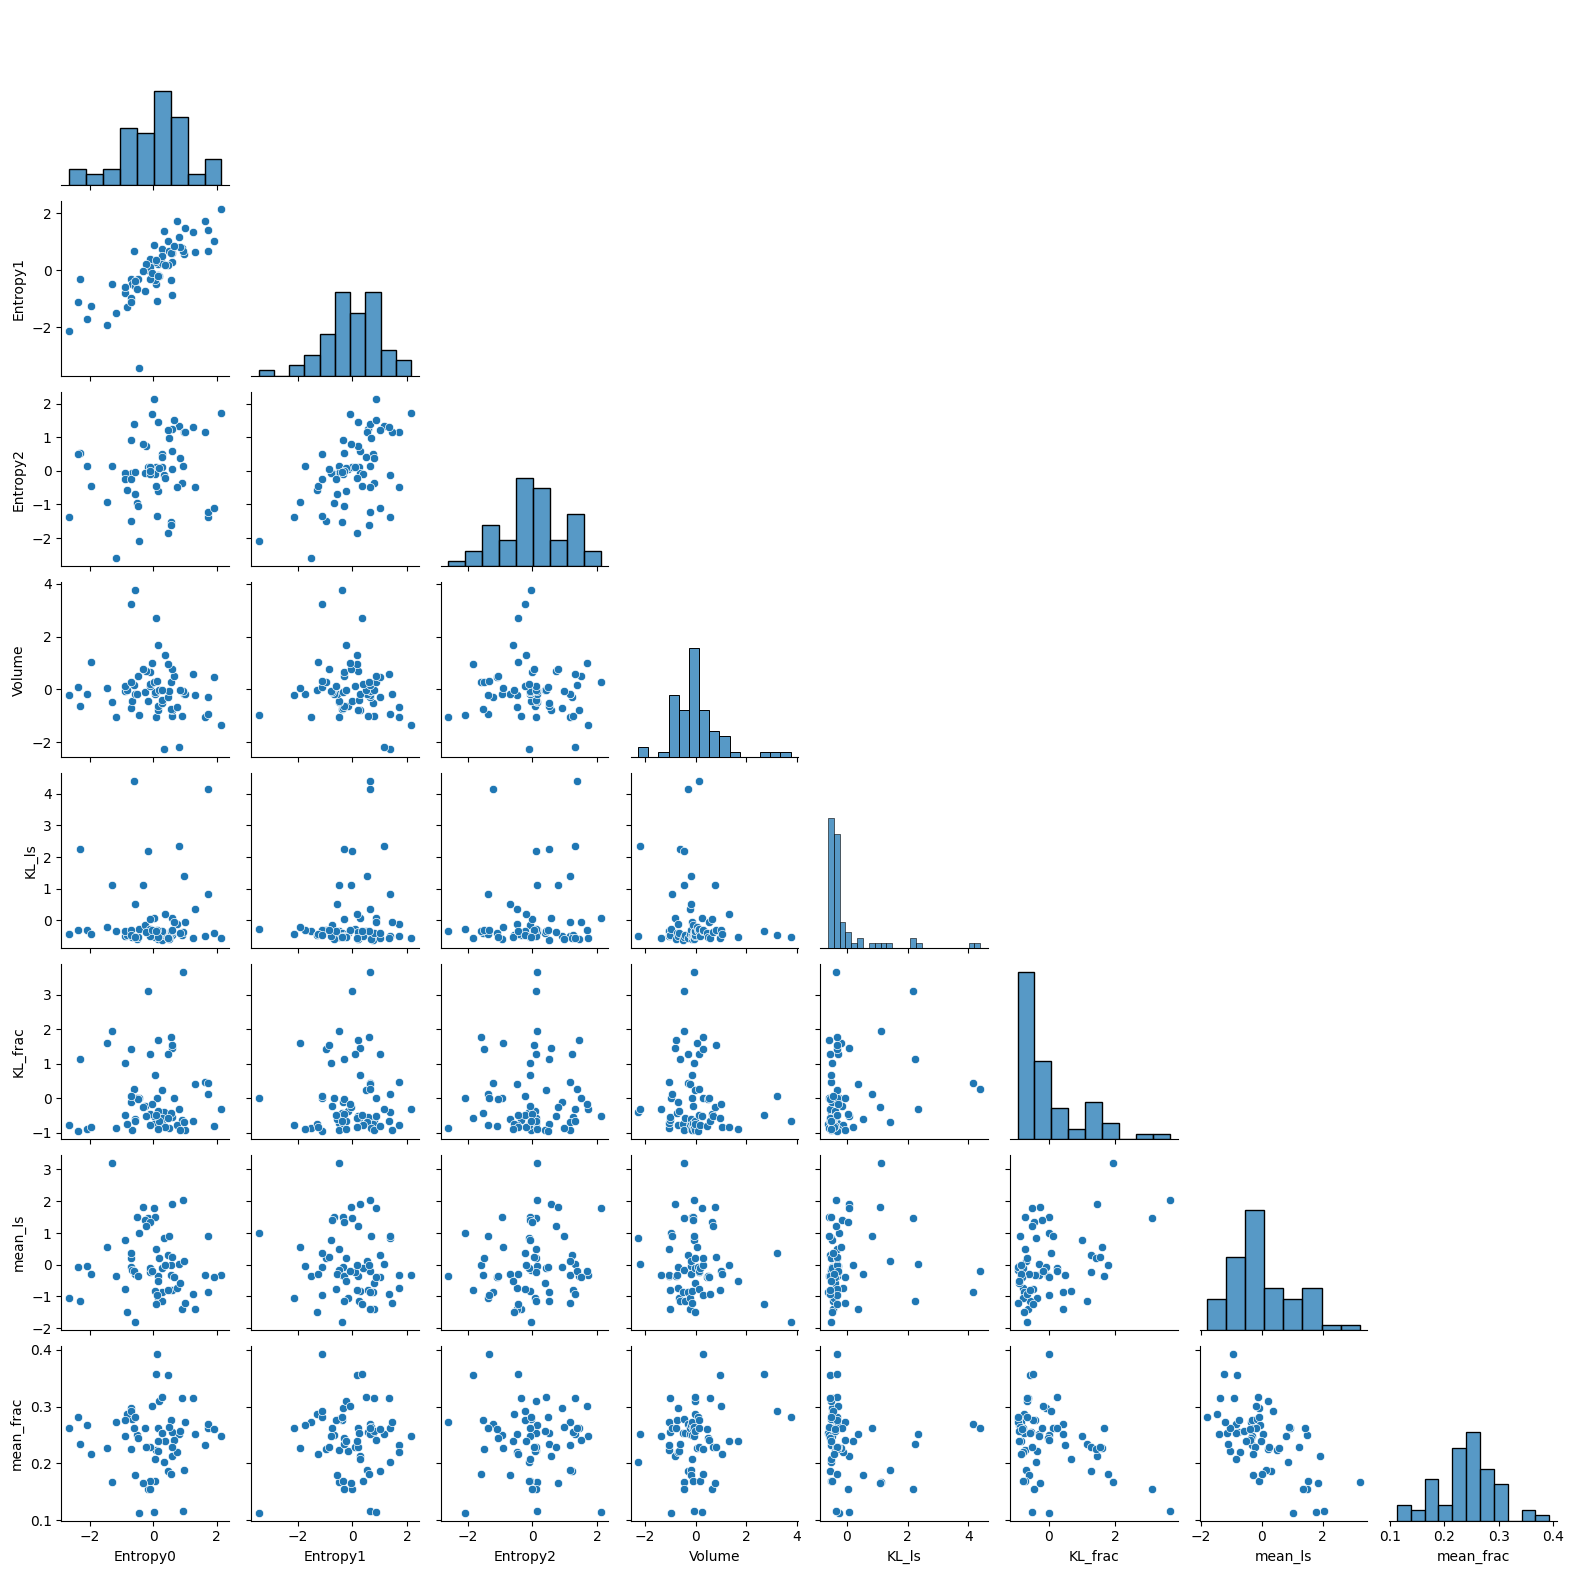

In [350]:
sns.pairplot(merged_df[['Entropy0','Entropy1','Entropy2','Volume','KL_ls','KL_frac','mean_ls','mean_frac']],corner=True, height=2)

In [355]:
kl_ls = merged_df['KL_ls']
E0 = merged_df['Entropy0']
E1 = merged_df['Entropy1']
E2 = merged_df['Entropy2']
Volume = merged_df['Volume']
ls = merged_df['mean_ls']
DGRP, mn_genotype = merged_df.DGRP.factorize()

In [356]:
#coords = {"genotype": mn_genotype}

with pm.Model() as model:
    beta_g = pm.Normal("beta_g", mu=0, sigma=5)
    beta_v = pm.Normal("beta_v", mu=0, sigma=5)
    beta_2 = pm.Normal("beta_2", mu=0, sigma=5)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=5)
    beta_0 = pm.Normal("beta_0", mu=0, sigma=5)
    intercept = pm.Normal("intercept", mu=0, sigma=5)
    
    mu = intercept + beta_0 * E0 + beta_1 * E1 + beta_2 * E2 + beta_v * Volume + beta_g * DGRP
    sigma = pm.Exponential("sigma", lam=1)  # Prior for the error term

    # Step 4: Define the likelihood
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=ls)


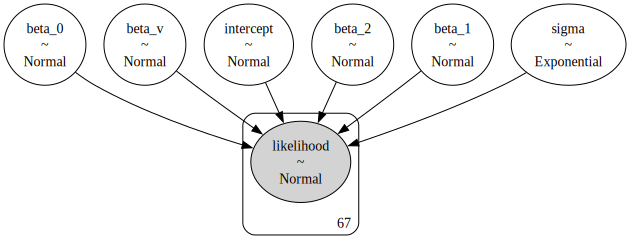

In [330]:
pm.model_to_graphviz(model)

In [357]:
with model:
    trace = pm.sample(3000, tune=10,chains=6, cores=-1,idata_kwargs={"log_likelihood": True} ) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (6 chains in 1 job)
NUTS: [beta_g, beta_v, beta_2, beta_1, beta_0, intercept, sigma]


Sampling 6 chains for 10 tune and 3_000 draw iterations (60 + 18_000 draws total) took 663 seconds.


array([[<Axes: title={'center': 'beta_g'}>,
        <Axes: title={'center': 'beta_g'}>],
       [<Axes: title={'center': 'beta_v'}>,
        <Axes: title={'center': 'beta_v'}>],
       [<Axes: title={'center': 'beta_2'}>,
        <Axes: title={'center': 'beta_2'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

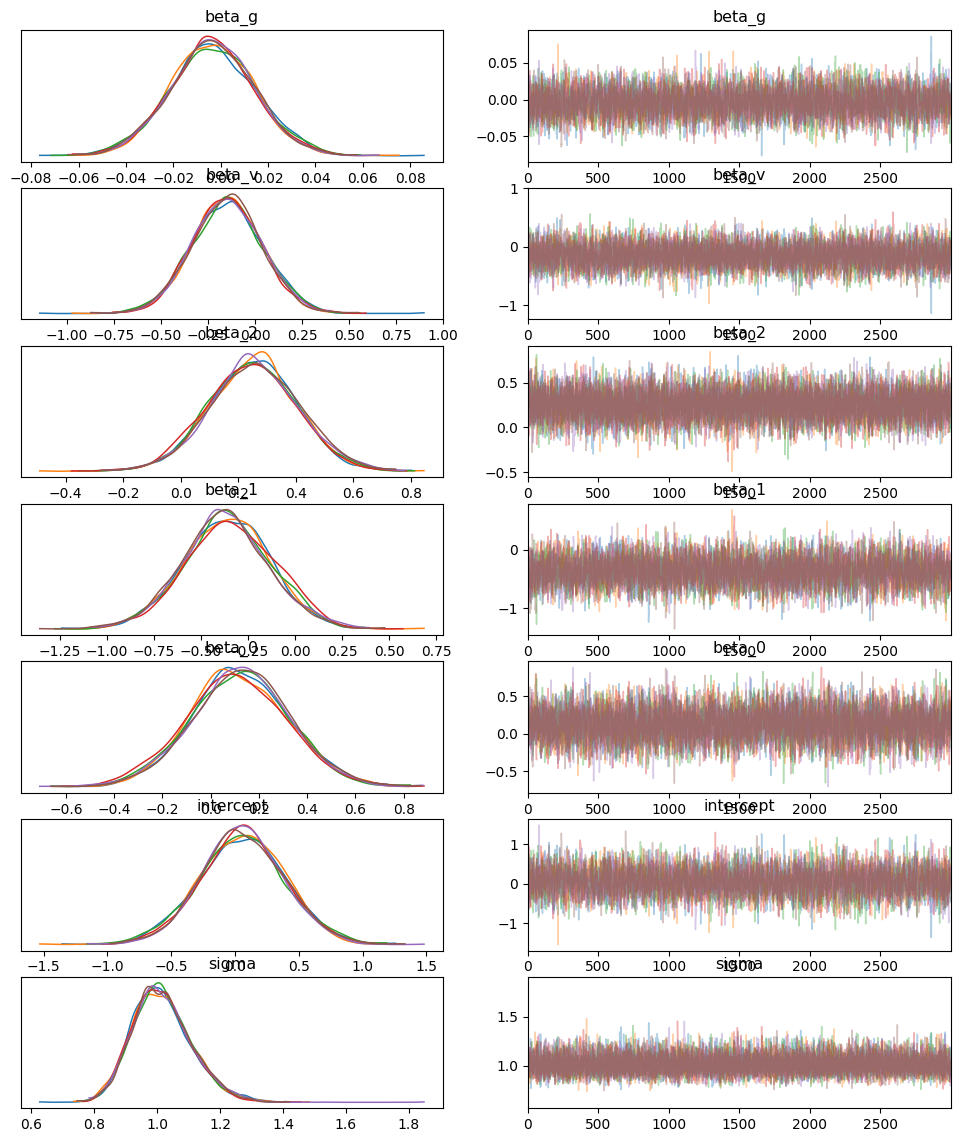

In [358]:
az.plot_trace(trace, compact=False)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

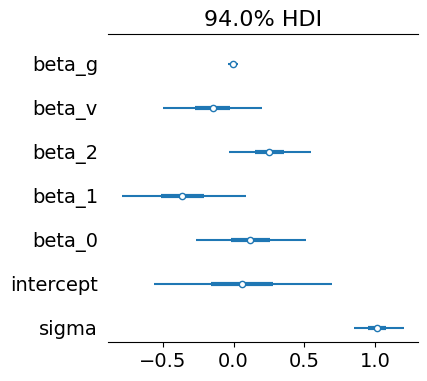

In [359]:
az.plot_forest(trace, figsize=(4,4), combined=True)

array([[<Axes: title={'center': 'beta_g'}>,
        <Axes: title={'center': 'beta_v'}>,
        <Axes: title={'center': 'beta_2'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>, <Axes: >, <Axes: >]],
      dtype=object)

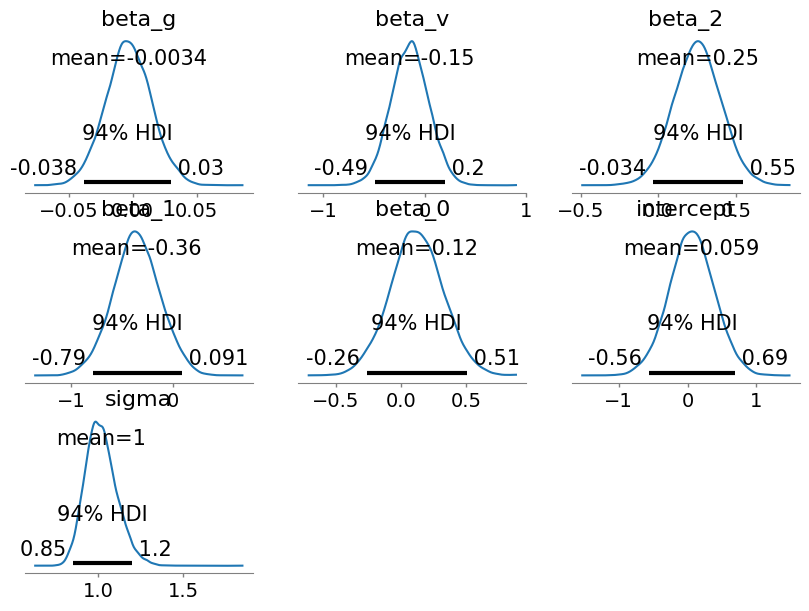

In [360]:
# Extract posterior and intervene on the different entropies
az.plot_posterior(trace, figsize=(10,7))

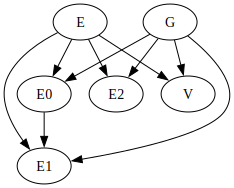

In [277]:
g = gr.Digraph()
g.edge(tail_name='G', head_name='V')
g.edge(tail_name='G', head_name='E0')
g.edge(tail_name='G', head_name='E1')
g.edge(tail_name='G', head_name='E2')
g.edge(tail_name='E', head_name='V')
g.edge(tail_name='E', head_name='E0')
g.edge(tail_name='E', head_name='E1')
g.edge(tail_name='E', head_name='E2')
g.edge(tail_name='E0', head_name='E1')
g


               do1          do2     contrast
count  1000.000000  1000.000000  1000.000000
mean      0.014187     0.166541     0.152354
std       1.077887     1.145976     1.380518
min      -3.713361    -3.313684    -4.364707
25%      -0.681459    -0.569422    -0.739987
50%       0.004791     0.149005     0.135942
75%       0.726618     0.887992     1.080725
max       3.378305     3.517562     5.156369


Text(0.5, 1.0, 'Do Entropy0')

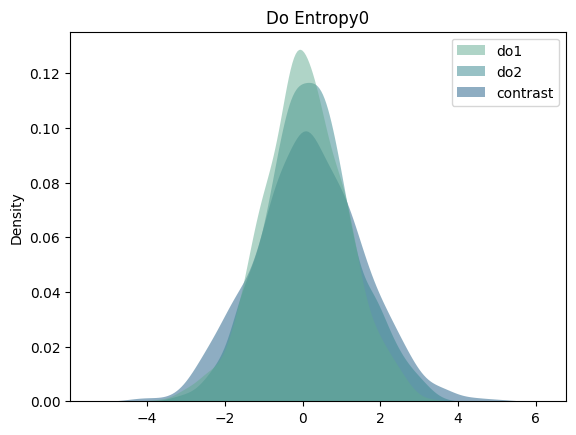

In [361]:
N = int(1e3)

e0 = np.random.choice(E0,N)
e1 = np.random.choice(E1,N)
e2 = np.random.choice(E2,N)
v = np.random.choice(Volume,N)
dgrp = np.random.choice(DGRP,N)

beta_0 = trace.posterior['beta_0'].mean()
beta_1 = trace.posterior['beta_1'].mean()
beta_2 = trace.posterior['beta_2'].mean()
beta_v = trace.posterior['beta_v'].mean()
beta_g = trace.posterior['beta_g'].mean()
intercept = trace.posterior['intercept'].mean()
sigma = trace.posterior['sigma'].mean()


do1 = np.random.normal(intercept.values + beta_0.values * 0 + beta_1.values * e1 + beta_2.values * e2 + beta_v.values * v + beta_g.values * dgrp, sigma.values, N )
do2 = np.random.normal(intercept.values + beta_0.values * 1 + beta_1.values * e1 + beta_2.values * e2 + beta_v.values * v+ beta_g.values * dgrp, sigma.values, N )
contrast = do2 - do1

df = pd.DataFrame({'do1': do1, 'do2': do2, 'contrast': contrast})

print(df.describe())

sns.kdeplot(df, fill=True, common_norm=True, palette="crest",
   alpha=.5, linewidth=0,)
plt.title('Do Entropy0')

               do1          do2     contrast
count  1000.000000  1000.000000  1000.000000
mean      0.017452    -0.354225    -0.371676
std       1.084476     1.032949     1.384601
min      -3.378743    -3.824360    -4.480378
25%      -0.694388    -1.057641    -1.314271
50%       0.000028    -0.302013    -0.379745
75%       0.771710     0.293250     0.604646
max       2.902397     3.019090     4.266573


Text(0.5, 1.0, 'Do Entropy1')

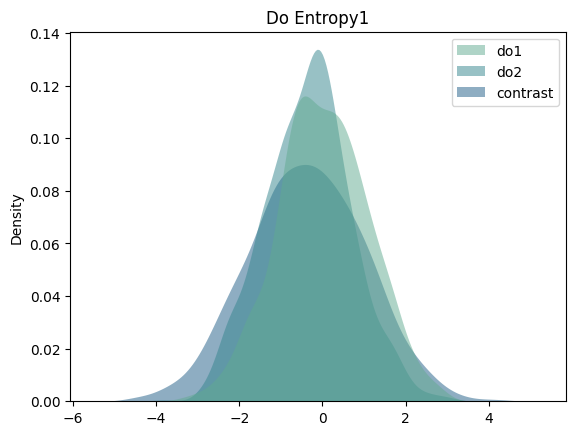

In [362]:
N = int(1e3)

e0 = np.random.choice(E0,N)
e1 = np.random.choice(E1,N)
e2 = np.random.choice(E2,N)
v = np.random.choice(Volume,N)
dgrp = np.random.choice(DGRP,N)

beta_0 = trace.posterior['beta_0'].mean()
beta_1 = trace.posterior['beta_1'].mean()
beta_2 = trace.posterior['beta_2'].mean()
beta_v = trace.posterior['beta_v'].mean()
beta_g = trace.posterior['beta_g'].mean()
intercept = trace.posterior['intercept'].mean()
sigma = trace.posterior['sigma'].mean()


do1 = np.random.normal(intercept.values + beta_0.values * e0 + beta_1.values * 0 + beta_2.values * e2 + beta_v.values * v+ beta_g.values * dgrp, sigma.values, N )
do2 = np.random.normal(intercept.values + beta_0.values * e0 + beta_1.values * 1 + beta_2.values * e2 + beta_v.values * v+ beta_g.values * dgrp, sigma.values, N )
contrast = do2 - do1

df = pd.DataFrame({'do1': do1, 'do2': do2, 'contrast': contrast})

print(df.describe())

sns.kdeplot(df, fill=True, common_norm=True, palette="crest",
   alpha=.5, linewidth=0,)
plt.title('Do Entropy1')

               do1          do2     contrast
count  1000.000000  1000.000000  1000.000000
mean     -0.002272     0.291227     0.293499
std       1.115750     1.085834     1.385301
min      -3.746187    -3.471684    -4.158170
25%      -0.781593    -0.439859    -0.624769
50%       0.007082     0.308646     0.267959
75%       0.738161     0.990711     1.247329
max       3.449556     3.586072     5.009918


Text(0.5, 1.0, 'Do Entropy2')

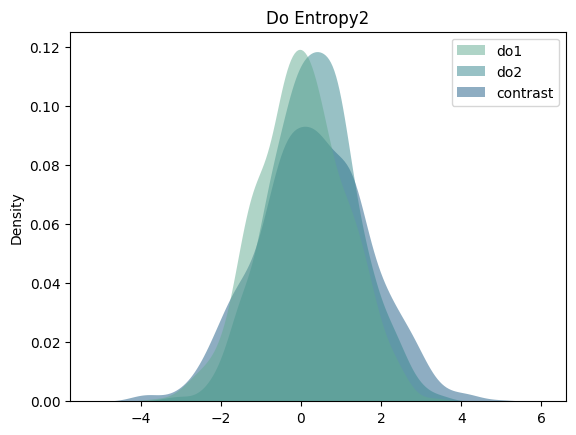

In [363]:
N = int(1e3)

e0 = np.random.choice(E0,N)
e1 = np.random.choice(E1,N)
e2 = np.random.choice(E2,N)
v = np.random.choice(Volume,N)
dgrp = np.random.choice(DGRP,N)

beta_0 = trace.posterior['beta_0'].mean()
beta_1 = trace.posterior['beta_1'].mean()
beta_2 = trace.posterior['beta_2'].mean()
beta_v = trace.posterior['beta_v'].mean()
beta_g = trace.posterior['beta_g'].mean()
intercept = trace.posterior['intercept'].mean()
sigma = trace.posterior['sigma'].mean()


do1 = np.random.normal(intercept.values + beta_0.values * e0 + beta_1.values * e1 + beta_2.values * 0 + beta_v.values * v+ beta_g.values * dgrp, sigma.values, N )
do2 = np.random.normal(intercept.values + beta_0.values * e0 + beta_1.values * e1 + beta_2.values * 1 + beta_v.values * v+ beta_g.values * dgrp, sigma.values, N )
contrast = do2 - do1

df = pd.DataFrame({'do1': do1, 'do2': do2, 'contrast': contrast})

print(df.describe())

sns.kdeplot(df, fill=True, common_norm=True, palette="crest",
   alpha=.5, linewidth=0,)
plt.title('Do Entropy2')

               do1          do2     contrast
count  1000.000000  1000.000000  1000.000000
mean      0.019513    -0.183446    -0.202960
std       1.125630     1.132043     1.459029
min      -3.132056    -4.420540    -4.802542
25%      -0.789441    -0.927583    -1.214006
50%      -0.000449    -0.222164    -0.180213
75%       0.807153     0.578754     0.778583
max       3.245865     4.107475     4.601011


Text(0.5, 1.0, 'Do Volume')

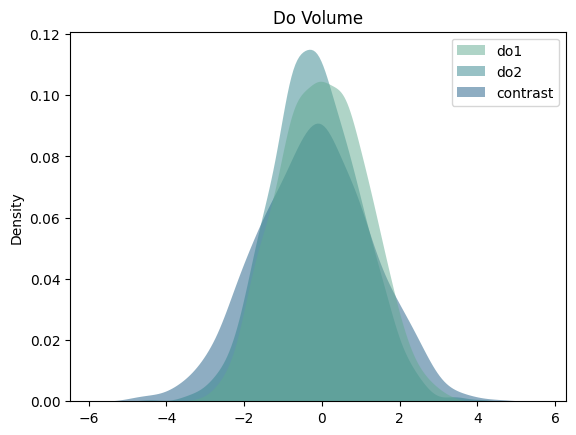

In [364]:
N = int(1e3)

e0 = np.random.choice(E0,N)
e1 = np.random.choice(E1,N)
e2 = np.random.choice(E2,N)
v = np.random.choice(Volume,N)
dgrp = np.random.choice(DGRP,N)

beta_0 = trace.posterior['beta_0'].mean()
beta_1 = trace.posterior['beta_1'].mean()
beta_2 = trace.posterior['beta_2'].mean()
beta_v = trace.posterior['beta_v'].mean()
beta_g = trace.posterior['beta_g'].mean()
intercept = trace.posterior['intercept'].mean()
sigma = trace.posterior['sigma'].mean()


do1 = np.random.normal(intercept.values + beta_0.values * e0 + beta_1.values * e1 + beta_2.values * e2 + beta_v.values * 0+ beta_g.values * dgrp, sigma.values, N )
do2 = np.random.normal(intercept.values + beta_0.values * e0 + beta_1.values * e1 + beta_2.values * e2 + beta_v.values * 1+ beta_g.values * dgrp, sigma.values, N )
contrast = do2 - do1

df = pd.DataFrame({'do1': do1, 'do2': do2, 'contrast': contrast})

print(df.describe())

sns.kdeplot(df, fill=True, common_norm=True, palette="crest",
   alpha=.5, linewidth=0,)
plt.title('Do Volume')

               do1          do2     contrast
count  1000.000000  1000.000000  1000.000000
mean      0.029455     0.021775    -0.007681
std       1.122545     1.140246     1.492641
min      -4.130890    -4.210274    -5.979985
25%      -0.735729    -0.721945    -1.028850
50%       0.021818     0.048128    -0.030288
75%       0.802162     0.706820     0.967971
max       4.128719     4.358327     6.855740


Text(0.5, 1.0, 'Do Genotype')

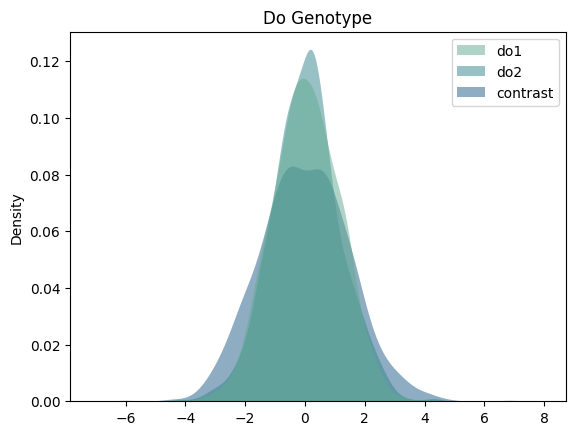

In [365]:
N = int(1e3)

e0 = np.random.choice(E0,N)
e1 = np.random.choice(E1,N)
e2 = np.random.choice(E2,N)
v = np.random.choice(Volume,N)
dgrp = np.random.choice(DGRP,N)

beta_0 = trace.posterior['beta_0'].mean()
beta_1 = trace.posterior['beta_1'].mean()
beta_2 = trace.posterior['beta_2'].mean()
beta_v = trace.posterior['beta_v'].mean()
beta_g = trace.posterior['beta_g'].mean()
intercept = trace.posterior['intercept'].mean()
sigma = trace.posterior['sigma'].mean()


do1 = np.random.normal(intercept.values + beta_0.values * e0 + beta_1.values * e1 + beta_2.values * e2 + beta_v.values * v+ beta_g.values * 0, sigma.values, N )
do2 = np.random.normal(intercept.values + beta_0.values * e0 + beta_1.values * e1 + beta_2.values * e2 + beta_v.values * v+ beta_g.values * 1, sigma.values, N )
contrast = do2 - do1

df = pd.DataFrame({'do1': do1, 'do2': do2, 'contrast': contrast})

print(df.describe())

sns.kdeplot(df, fill=True, common_norm=True, palette="crest",
   alpha=.5, linewidth=0,)
plt.title('Do Genotype')